In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.viewer.mpl import drawMesh

from pygimli.physics import TravelTimeManager

28/07/23 - 20:07:42 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


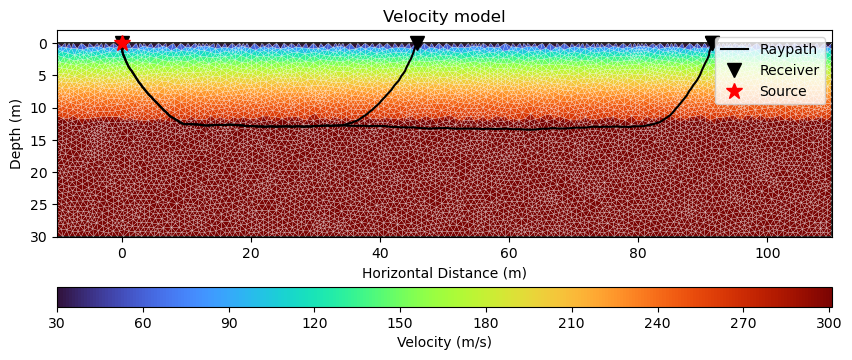

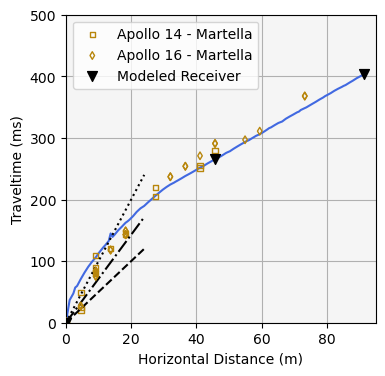

In [3]:
##~~~~~~~~~~~~~~~~~
## Generate the mesh


def first_layer_vel(depth):
    """
    Equation that defines the shallow (<10m) regolith
    velocity profile
    """
    vel = 55 * (depth/0.01)**(1/6.)
    return vel

def amos_vp(depth):
    multiplier = 1.5
    divider = 0.000022
    power = 0.42
    vel = multiplier * (depth/divider)**power
    return vel

def fit_vel(depth):
    multiplier = 1
    divider = 0.00000075
    power = 1/3
    vel = multiplier * (depth/divider)**power
    return vel

def apollo_fit_vel(depth):
    """
    Use the BA model +PR fit, adjust RP model parameters
    (i.e. contact ratio) to try to make a velocity
    profile that is consistent with Apollo observations
    """
    multiplier = 1.5
    divider = 0.000004
    power = 0.35
    vel = multiplier * (depth/divider)**power
    return vel

def gangi_vel(depth):
    """
    From gangi and Yen 1979
    """
    vel = 220*depth**(1/6)
    return vel


second_layer_depth = 12
second_layer_velocity = 332.




sensors = np.linspace(0, 91.4, 21)
plc = mt.createWorld([-10, -30], [110, 0], worldMarker=False)
for pos in sensors:
    plc.createNode([pos, 0.0])
mesh_gradient = mt.createMesh(plc, quality=33, area=0.5, smooth=[1,10])


vel_gradient = []
for node in mesh_gradient.nodes():
    
    if node.y() < -1*second_layer_depth:
        vel_gradient.append(second_layer_velocity)
    else:
        # vel_gradient.append(first_layer_vel(abs(node.y())))
        # vel_gradient.append(gangi_vel(abs(node.y())))
        vel_gradient.append(amos_vp(abs(node.y()))*.7)  #reduce for anisotropy
    
    
vel_gradient = pg.meshtools.nodeDataToCellData(mesh_gradient,
                                               np.array(vel_gradient))



##~~~~~~~~~~~~~~~~~
## Raytrace Plot

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# for boundary in mesh_gradient.boundaries():
#     boundary.setMarker(0)

mesh_gradient.createNeighborInfos()

# In order to use the Dijkstra, we extract the surface positions >0
mx = pg.x(mesh_gradient)
my = pg.y(mesh_gradient)
px = np.sort(mx[my == 0.0])

# A data container with index arrays named s (shot) and g (geophones) is
# created and filled with the positions and shot/geophone indices.
data = pg.DataContainer()
data.registerSensorIndex('s')
data.registerSensorIndex('g')

nData = 0
comp_offsets = []
for i, pxi in enumerate(px):
    if not 0<=pxi<92:
        continue
    data.createSensor([pxi, 0.0])
    nData += 1
    comp_offsets.append(pxi)
    # if pxi == 0.0:
    #     source = i
comp_offsets = np.array(comp_offsets)
source = 0

# nData = len(px)
data.resize(nData)
data['s'] = [source] * nData # only one shot at first sensor
data['g'] = range(nData)  # and all sensors are receiver geophones

# Draw initial mesh with velocity distribution
vel_plot, cb = pg.show(mesh_gradient, vel_gradient, ax=ax, label="Velocity (m/s)", hold=True,
        logScale=False, cMap="turbo", coverage=None)
drawMesh(ax, mesh_gradient, color="white", lw=0.21)


sec_nodes = 5
mgr = TravelTimeManager()
recs = [0, 45.7, 91.4]

res = mgr.simulate(vel=vel_gradient, scheme=data, mesh=mesh_gradient, secNodes=sec_nodes)
t_all = res['t'].array()

for r, p in enumerate(recs):
    if r == 0:
        lab = "Raypath"
    else:
        lab = None
    recNode = mgr.fop.mesh().findNearestNode([sensors[(np.abs(sensors-p)).argmin()], 0.0])
    sourceNode = mgr.fop.mesh().findNearestNode([0.0, 0.0])

    path = mgr.fop.dijkstra.shortestPath(sourceNode, recNode)
    points = mgr.fop.mesh().positions(withSecNodes=True)[path].array()
    ax.plot(points[:,0], points[:,1], "black", label=lab)


# Draw sensor positions for the selected receivers
for p in recs:
    ax.plot(sensors[(np.abs(sensors-p)).argmin()], 0.0, "kv", ms=10)
ax.plot(sensors[(np.abs(sensors-p)).argmin()], 0.0, "kv", ms=10, label='Receiver')  # double plotting last one for the label
ax.plot(0.0, 0.0, "r*", ms=12, label='Source')
ax.set_ylim(mesh_gradient.ymin(), 2)

## Control the colorbar in the plot
min_c = 30
max_c = 301
tick_increment = 30
ticks = np.arange(min_c, max_c, tick_increment)
cb.mappable.set_clim(min_c, max_c)
cb.ax.xaxis.set_ticks(ticks)
# cb.solids.set_edgecolor("face")  # gets rid of weird lines

ax.set_title("Velocity model")
ax.set_xlabel("Horizontal Distance (m)")
ax.legend()
ticks =  ax.get_yticks()
ax.set_yticks(ticks=ticks,
              labels=np.abs(ticks).astype("int"))
ax.set_ylim(-30, 2)
ax.set_ylabel("Depth (m)")
plt.show()



##~~~~~~~~~~~~~~~~~
## Traveltime Plot
vel_data_path = '../data/Martella_Apollo_14.txt'
ap14_vels = np.genfromtxt(vel_data_path, dtype=np.float32, skip_header=1, encoding='utf-8')
vel_data_path = '../data/Martella_Apollo_16.txt'
ap16_vels = np.genfromtxt(vel_data_path, dtype=np.float32, skip_header=1, encoding='utf-8')


## Average vel lines
avg_vel1 = 100
avg_vel2 = 140
avg_vel3 = 200
avg_val_compdist = 25  #offset distance over which to plot layer 1 avg vel
avg_plot_dist = np.arange(avg_val_compdist)
avg_times1 = avg_plot_dist/(avg_vel1/1000)
avg_times2 = avg_plot_dist/(avg_vel2/1000)
avg_times3 = avg_plot_dist/(avg_vel3/1000)


fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharex=False)
ax.plot(comp_offsets, t_all * 1000, zorder=1, color="royalblue")
ax.scatter(ap14_vels[:,0],ap14_vels[:,1], marker='s', edgecolors='darkgoldenrod', s=15, 
           facecolors='None', label='Apollo 14 - Martella', zorder=2)
ax.scatter(ap16_vels[:,0],ap16_vels[:,1], marker='d', edgecolors='darkgoldenrod', s=15, 
           facecolors='None', label='Apollo 16 - Martella', zorder=3)

gidxs = []
for p in recs:
    curr_gidx = (np.abs(comp_offsets-p)).argmin()
    gidxs.append(curr_gidx)
ax.scatter(comp_offsets[gidxs], t_all[gidxs] * 1000, marker='v', c='black', s=50,
          label='Modeled Receiver', zorder=3)
ax.set(ylabel="Traveltime (ms)",
      xlabel="Horizontal Distance (m)",
      axisbelow=True,
      facecolor="whitesmoke")

ax.plot(avg_plot_dist, avg_times1, ls=":", color="black")
ax.plot(avg_plot_dist, avg_times2, ls="-.", color="black")
ax.plot(avg_plot_dist, avg_times3, ls="--", color="black")

ax.grid("both")
ax.legend()
plt.xlim(0,95)
plt.ylim(0,500)
plt.show()

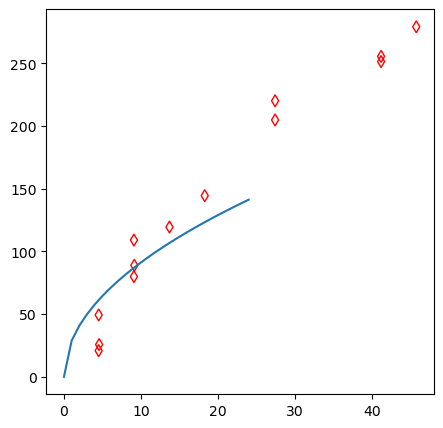

In [3]:
from scipy.optimize import curve_fit

def first_layer_vel_eq(Z, V0, Z0, E):
    """
    Equation that defines the shallow (<10m) regolith
    velocity profile
    """
    vel = V0 * (abs(Z)/Z0)**(1/E)
    return vel

offset_cutoff_idx = 8  # how many data points are in shallow layer +1
xdata = ap14_vels[:offset_cutoff_idx,0]
ydata = ap14_vels[:offset_cutoff_idx,1]

popt, pcov = curve_fit(first_layer_vel_eq, xdata, ydata,
                      bounds=([0.,0.,2.],[np.inf, np.inf, 6.]))

# print(popt)


xplot = np.arange(0,25)
vels = []
for z in xplot:
    vel = first_layer_vel_eq(z, popt[0], popt[1], popt[2])
    vels.append(vel)


fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=False)
ax.scatter(ap14_vels[:,0],ap14_vels[:,1], marker='d', edgecolors='red', 
           facecolors='None', label='Martella')

ax.plot(xplot, vels)

plt.show()


02/07/23 - 16:28:15 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Raytracing with 5 secondary nodes: Elapsed time is 5.61 seconds.


C:\Users\amos\AppData\Local\Temp\ipykernel_19020\734292081.py:183: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(abs(tick)) for tick in ticks])


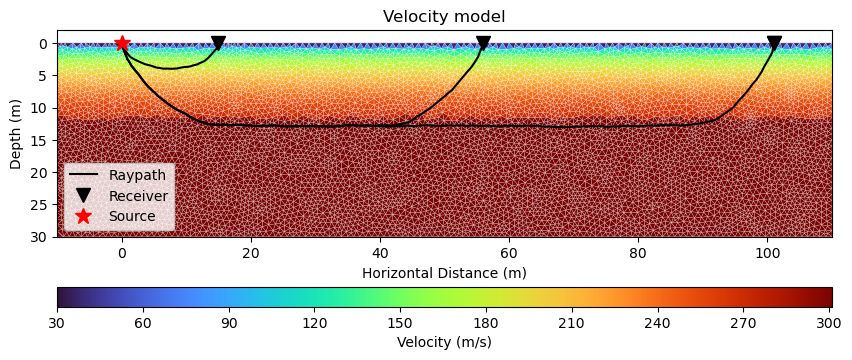

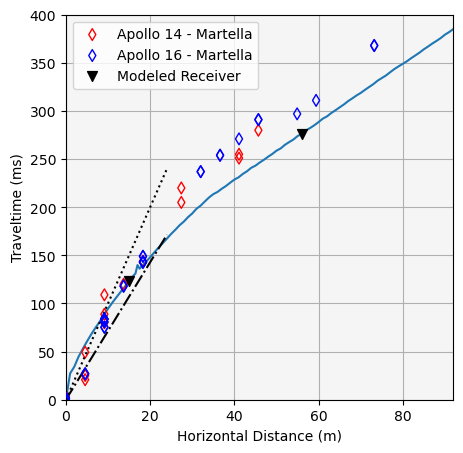

In [9]:
##~~~~~~~~~~~~~~~~~
## Generate the mesh


def first_layer_vel(node):
    """
    Equation that defines the shallow (<10m) regolith
    velocity profile
    """
    vel = 55 * (abs(node.y())/0.01)**(1/6.)
    return vel

# def first_layer_vel(node):
#     """
#     play with 1/3 power vels, can this fit?
#     """
#     vel = 20 * (abs(node.y())/0.005)**(1/3)
#     return vel

def amos_vp(depth):
    multiplier = 1.5
    divider = 0.000022
    power = 0.42
    vel = multiplier * (depth/divider)**power
    return vel

def fit_vel(depth):
    multiplier = 1
    divider = 0.00000075
    power = 1/3
    vel = multiplier * (depth/divider)**power
    return vel

def apollo_fit_vel(depth):
    """
    Use the BA model +PR fit, adjust RP model parameters
    (i.e. contact ratio) to try to make a velocity
    profile that is consistent with Apollo observations
    """
    multiplier = 1.5
    divider = 0.000004
    power = 0.35
    vel = multiplier * (depth/divider)**power
    return vel

# def fit_vel(depth):
#     multiplier = 2.5
#     divider = 0.00000000005
#     power = 1/6
#     vel = multiplier * (depth/divider)**power
#     return vel
    

second_layer_depth = 12
second_layer_velocity = 332.




sensors = np.arange(110, step=1.)
plc = mt.createWorld([-10, -30], [110, 0], worldMarker=False)
for pos in sensors:
    plc.createNode([pos, 0.0])
mesh_gradient = mt.createMesh(plc, quality=33, area=0.5, smooth=[1,10])


vel_gradient = []
for node in mesh_gradient.nodes():

    # vel_gradient.append(fit_vel(abs(node.y())))
    
    if node.y() < -1*second_layer_depth:
        vel_gradient.append(second_layer_velocity)
    else:
        # vel_gradient.append(first_layer_vel(node))
        # vel_gradient.append(amos_vp(abs(node.y())))
        vel_gradient.append(apollo_fit_vel(abs(node.y())))
    
    
vel_gradient = pg.meshtools.nodeDataToCellData(mesh_gradient,
                                               np.array(vel_gradient))



##~~~~~~~~~~~~~~~~~
## Raytrace Plot

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for boundary in mesh_gradient.boundaries():
    boundary.setMarker(0)

xmin, xmax = mesh_gradient.xmin(), mesh_gradient.xmax()
mesh_gradient.createNeighborInfos()

# In order to use the Dijkstra, we extract the surface positions >0
mx = pg.x(mesh_gradient)
my = pg.y(mesh_gradient)
px = np.sort(mx[my == 0.0])

# A data container with index arrays named s (shot) and g (geophones) is
# created and filled with the positions and shot/geophone indices.
data = pg.DataContainer()
data.registerSensorIndex('s')
data.registerSensorIndex('g')

for i, pxi in enumerate(px):
    data.createSensor([pxi, 0.0])
    if pxi == 0.0:
        source = i

nData = len(px)
data.resize(nData)
data['s'] = [source] * nData # only one shot at first sensor
data['g'] = range(nData)  # and all sensors are receiver geophones

# Draw initial mesh with velocity distribution
vel_plot, cb = pg.show(mesh_gradient, vel_gradient, ax=ax, label="Velocity (m/s)", hold=True,
        logScale=False, cMap="turbo", coverage=None)
drawMesh(ax, mesh_gradient, color="white", lw=0.21)

# We compare the accuracy for 0-5 secondary nodes
sec_nodes = [5]
t_all = []
durations = []
paths = []

mgr = TravelTimeManager()

cols = ['black', 'red','blue']
recs = [15, 56, 101]

for i, n in enumerate(sec_nodes):

    # Perform traveltime calculations and log time with pg.tic() & pg.toc()
    pg.tic()
    res = mgr.simulate(vel=vel_gradient, scheme=data, mesh=mesh_gradient, secNodes=n)
    # We need to copy res['t'] here because res['t'] is a reference to
    # an array in res, and res will be removed in the next iteration.
    # Unfortunately, we don't have any reverence counting for core objects yet.
    t_all.append(res['t'].array())
    durations.append(pg.dur())
    pg.toc("Raytracing with %d secondary nodes:" % n)

    for r, p in enumerate(recs):
        if r == 0:
            lab = "Raypath"
        else:
            lab = None

        recNode = mgr.fop.mesh().findNearestNode([sensors[p], 0.0])
        sourceNode = mgr.fop.mesh().findNearestNode([0.0, 0.0])

        path = mgr.fop.dijkstra.shortestPath(sourceNode, recNode)
        points = mgr.fop.mesh().positions(withSecNodes=True)[path].array()
        ax.plot(points[:,0], points[:,1], cols[i], label=lab)


        
        


# Draw sensor positions for the selected receivers
for p in recs:
    ax.plot(sensors[p], 0.0, "kv", ms=10)
ax.plot(sensors[p], 0.0, "kv", ms=10, label='Receiver')  # double plotting last one for the label
ax.plot(0.0, 0.0, "r*", ms=12, label='Source')
ax.set_ylim(mesh_gradient.ymin(), 2)

## Control the colorbar in the plot
min_c = 30
max_c = 301
tick_increment = 30
ticks = np.arange(min_c, max_c, tick_increment)
cb.mappable.set_clim(min_c, max_c)
cb.ax.xaxis.set_ticks(ticks)
# cb.solids.set_edgecolor("face")  # gets rid of weird lines

ax.set_title("Velocity model")
ax.set_xlabel("Horizontal Distance (m)")
ax.legend()
ticks =  ax.get_yticks()
ax.set_yticklabels([int(abs(tick)) for tick in ticks])
ax.set_ylabel("Depth (m)")
plt.show()



##~~~~~~~~~~~~~~~~~
## Traveltime Plot
vel_data_path = '../data/Martella_Apollo_14.txt'
ap14_vels = np.genfromtxt(vel_data_path, dtype=np.float32, skip_header=1, encoding='utf-8')
vel_data_path = '../data/Martella_Apollo_16.txt'
ap16_vels = np.genfromtxt(vel_data_path, dtype=np.float32, skip_header=1, encoding='utf-8')


## Average vel lines
avg_vel1 = 100
avg_vel2 = 140
avg_val_compdist = 25  #offset distance over which to plot layer 1 avg vel
avg_plot_dist = np.arange(avg_val_compdist)
avg_times1 = avg_plot_dist/(avg_vel1/1000)
avg_times2 = avg_plot_dist/(avg_vel2/1000)


fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=False)
for i, n in enumerate(sec_nodes):
    ax.plot(px, t_all[i] * 1000, zorder=1)
ax.scatter(ap14_vels[:,0],ap14_vels[:,1], marker='d', edgecolors='red', 
           facecolors='None', label='Apollo 14 - Martella', zorder=2)
ax.scatter(ap16_vels[:,0],ap16_vels[:,1], marker='d', edgecolors='blue', 
           facecolors='None', label='Apollo 16 - Martella', zorder=3)

gidxs = []
for p in recs:
    curr_gidx = (np.abs(px - p)).argmin()
    gidxs.append(curr_gidx)
ax.scatter(px[gidxs], t_all[0][gidxs] * 1000, marker='v', c='black', s=50,
          label='Modeled Receiver', zorder=3)
ax.set(ylabel="Traveltime (ms)",
      xlabel="Horizontal Distance (m)",
      axisbelow=True,
      facecolor="whitesmoke")

ax.plot(avg_plot_dist, avg_times1, ls=":", color="black")
ax.plot(avg_plot_dist, avg_times2, ls="-.", color="black")

ax.grid("both")
ax.legend()
plt.xlim(0,92)
plt.ylim(0,400)
plt.show()